# Task 3 [3p]

Suppose that we have two languages: Upper and Lower. This is an example Upper sentence:

<pre>
THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.
</pre>

And this is its translation into Lower:

<pre>
the quick brown fox jumps over the lazy dog
</pre>

You have two corpora for these languages (with different sentences); see files [polish_lower](https://drive.google.com/file/d/1H1WMHpf3UXe2Q_QrhuvbxPTbsinvHIHr/view?usp=drive_link), [polish_upper](https://drive.google.com/file/d/1H5117jA6VKiGEizqu15ap6eWkDdbE02t/view?usp=drive_link) . Your task is to train word embedings for both languages together, so as to make embeddings of the words which are its translations as close as possible. But unfortunately, you have the budget which allows you to prepare the translation only for 1000 words (we call it D, you have to deside which words you want to be in D)

Prepare the corpora wich contains three kind of sentences:
* Upper corpus sentences
* Lower corpus sentences
* sentences derived from Upper/Lower corpus, modified using D

There are many possible ways of doing this, for instance this one (ROT13.COM: hfr rirel fragrapr sebz obgu pbecben gjvpr: jvgubhg nal zbqvsvpngvbaf, naq jvgu rirel jbeqf sebz Q ercynprq ol vgf genafyngvba)

We define the score for an Upper WORD as  $\frac{1}{p}$, where $p$ is a position of its translation in the list of **Lower** words most similar to WORD. For instance, when most similar words to DOG are:

<pre>
WOLF, CAT, WOLVES, LION, gopher, dog
</pre>

then the score for the word DOG is 0.5. Compute the average score separately for words from D, and for words out of D (hint: if the computation takes to much time do it for a random sample).

Present embedding using the PCA method or t-SNE. You can use sklearn or any other library for this.


In [1]:
import numpy as np
import random
import gensim
from gensim.models import Word2Vec
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
with open("input/task3_polish_upper.txt", "r", encoding="utf-8") as f:
    upper_sentences = [line.strip().split() for line in f.readlines()]

with open("input/task3_polish_lower.txt", "r", encoding="utf-8") as f:
    lower_sentences = [line.strip().split() for line in f.readlines()]


In [3]:
# frequency-based dictionary D (1000 most frequent word pairs)
def extract_word_pairs(upper, lower):
    up_flat = [word for sent in upper for word in sent]
    low_flat = [word for sent in lower for word in sent]
    common = set(w.lower() for w in up_flat) & set(low_flat)
    word_counts = Counter([w for w in low_flat if w in common])
    selected_words = [w for w, _ in word_counts.most_common(1000)]
    D = {w.upper(): w for w in selected_words}
    return D

D = extract_word_pairs(upper_sentences, lower_sentences)


In [4]:
# mixed corpus with translations
def mix_corpora(upper, lower, D):
    mixed_sentences = []
    for sentence in upper:
        new_sent = [D.get(w, w) for w in sentence]
        mixed_sentences.append(new_sent)
    return upper + lower + mixed_sentences

all_sentences = mix_corpora(upper_sentences, lower_sentences, D)


In [5]:
model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=6, epochs=10)


In [6]:
# evaluate translation quality
def compute_score(model, D, all_words, sample_size=1000):
    in_d_scores, out_d_scores = [], []

    for word in tqdm(random.sample(all_words, sample_size)):
        if word.upper() not in model.wv or word.lower() not in model.wv:
            continue
        try:
            similar = [w for w, _ in model.wv.most_similar(word.upper(), topn=100)]
            if word.lower() in similar:
                rank = similar.index(word.lower()) + 1
                score = 1.0 / rank
            else:
                score = 0.0
            if word.upper() in D:
                in_d_scores.append(score)
            else:
                out_d_scores.append(score)
        except KeyError:
            continue

    return in_d_scores, out_d_scores

all_unique_words = list(set(w.lower() for s in lower_sentences for w in s))
in_d_scores, out_d_scores = compute_score(model, D, all_unique_words)


100%|██████████| 1000/1000 [00:02<00:00, 439.87it/s]


In [7]:
print(f"Average score for in-D words: {np.mean(in_d_scores):.4f}")
print(f"Average score for out-of-D words: {np.mean(out_d_scores):.4f}")


Average score for in-D words: 0.6068
Average score for out-of-D words: 0.0719


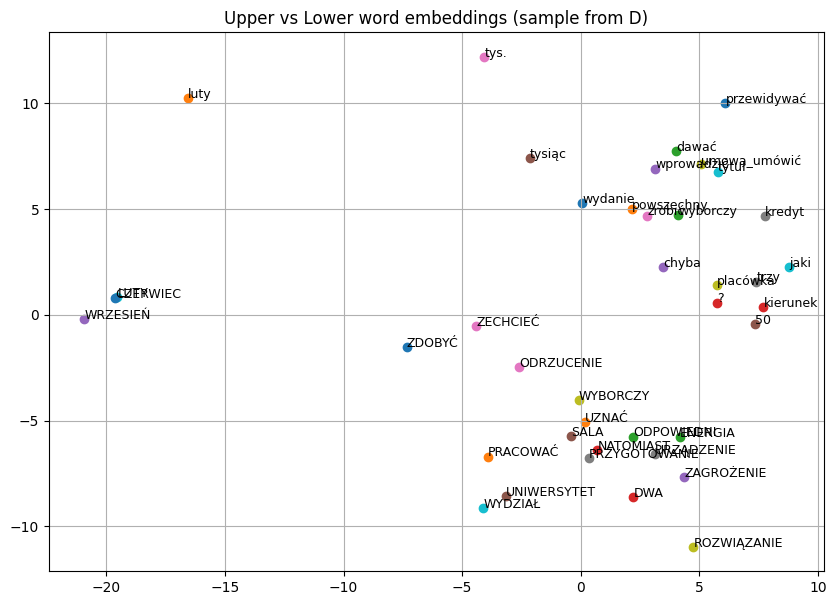

In [ ]:
def visualize_words(model, words, title):
    vectors = [model.wv[w] for w in words if w in model.wv]
    labels = [w for w in words if w in model.wv]

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 7))
    for i, word in enumerate(labels):
        plt.scatter(reduced[i, 0], reduced[i, 1])
        plt.text(reduced[i, 0]+0.01, reduced[i, 1]+0.01, word, fontsize=9)
    plt.title(title)
    plt.grid(True)
    plt.show()

sample_words = random.sample(list(D.keys()), 20) + [D[k] for k in random.sample(list(D.keys()), 20)]
visualize_words(model, sample_words, "Upper vs Lower word embeddings (sample from D)")


In [ ]:
def print_neighbours(model, word, topn=10):
    if word in model.wv:
        neighbours = model.wv.most_similar(word, topn=topn)
        print(f"Top {topn} neighbours for '{word}':")
        for neighbour, similarity in neighbours:
            print(f"{neighbour}: {similarity:.4f}")
    else:
        print(f"Word '{word}' not in vocabulary.")

print_neighbours(model, 'BYĆ')

Top 10 neighbours for 'BYĆ':
BYĆ_BYŁY: 0.8967
STAN_STANOWIĆ_STANOWY: 0.6994
POZOSTAWAĆ: 0.6708
ZOSTAĆ: 0.6310
STANOWIĆ: 0.6271
BYCIE_BYĆ: 0.6264
ISTNIEĆ: 0.6102
BYWAĆ: 0.6063
MIEĆ_MÓJ: 0.6055
JAKO: 0.5912
